In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Calculate IoU

In [31]:
import os
import json
import pandas as pd
import numpy as np
import ast
from collections import defaultdict

def convert_bbox_format(bbox):
    left, top, width, height = bbox
    right = left + width
    bottom = top + height
    return [left, top, right, bottom]

def calculate_iou(bbox1, bbox2):
    # Convert the bounding boxes to [left, top, right, bottom] format
    bbox1 = convert_bbox_format(bbox1)
    bbox2 = convert_bbox_format(bbox2)

    left1, top1, right1, bottom1 = bbox1
    left2, top2, right2, bottom2 = bbox2

    # Calculate intersection coordinates
    inter_left = max(left1, left2)
    inter_top = max(top1, top2)
    inter_right = min(right1, right2)
    inter_bottom = min(bottom1, bottom2)

    # Calculate intersection area
    inter_width = max(0, inter_right - inter_left)
    inter_height = max(0, inter_bottom - inter_top)
    inter_area = inter_width * inter_height

    # Calculate area of each bounding box
    area1 = (right1 - left1) * (bottom1 - top1)
    area2 = (right2 - left2) * (bottom2 - top2)

    # Calculate union area
    union_area = area1 + area2 - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

def calculate_iou_at_0_5(preds, data):
    objectcnt = defaultdict(int)
    objectcorrect = defaultdict(int)
    total_iou_0_5 = 0
    all_boxes = 0
    counter = 0
    for instance in data:
        for annotation in instance["annotations"]:
            iou = calculate_iou(ast.literal_eval(preds.loc[counter, "bbox"]), annotation["bbox"])
            counter += 1
            objectcnt[annotation['caption']] += 1
            if iou >= 0.5:
                objectcorrect[annotation['caption']] += 1
                total_iou_0_5 += 1
            all_boxes += 1

    return total_iou_0_5, all_boxes, objectcnt, objectcorrect

existing_data = []
input_json_path = os.path.join('/content/drive/MyDrive/TIL_personal/annotations.json')
with open(input_json_path, 'r') as json_file:
    existing_data = json.load(json_file)

preds = pd.read_csv("/content/drive/MyDrive/TIL_personal/vlm_results_yolo-ep65-aug-siglip-so400m-epoch18-aug-upscale-conf0.1.csv")

total_iou_0_5_score, all_boxes, objectcnt, objectcorrect = calculate_iou_at_0_5(preds, existing_data)
print(f"IoU@0.5 score: {total_iou_0_5_score/all_boxes}")
for key, value in objectcnt.items():
  if objectcorrect[key]/value < 0.5:
    print(f"{key}: Total {value}, Correct {objectcorrect[key]}, % Correct {objectcorrect[key]/value}")

IoU@0.5 score: 0.5925
grey and white fighter plane: Total 43, Correct 18, % Correct 0.4186046511627907
grey missile: Total 76, Correct 21, % Correct 0.27631578947368424
yellow and red hot air balloon: Total 27, Correct 3, % Correct 0.1111111111111111
blue fighter jet: Total 52, Correct 7, % Correct 0.1346153846153846
grey fighter jet: Total 116, Correct 54, % Correct 0.46551724137931033
grey drone: Total 96, Correct 43, % Correct 0.4479166666666667
blue fighter plane: Total 83, Correct 3, % Correct 0.03614457831325301
white fighter plane: Total 33, Correct 12, % Correct 0.36363636363636365
white and blue drone: Total 49, Correct 15, % Correct 0.30612244897959184
white missile: Total 77, Correct 31, % Correct 0.4025974025974026
white and black airship: Total 22, Correct 10, % Correct 0.45454545454545453
white blimp: Total 23, Correct 6, % Correct 0.2608695652173913
white glider: Total 22, Correct 7, % Correct 0.3181818181818182


#Concat csv and json bboxes

In [21]:
import json
import random
import pandas as pd
import ast

# Load the JSON data from the file
with open('/content/drive/MyDrive/TIL_personal/annotations.json', 'r') as file:
    data = json.load(file)

preds = pd.read_csv("/content/drive/MyDrive/TIL_personal/vlm_results_yolo-ep65-aug-siglip-so400m-epoch18-aug-upscale-conf0.1.csv")

counter = 0
# Modify each image entry to include new set of bounding boxes
for image_entry in data:
    original_annotations = image_entry['annotations']

    for annotation in original_annotations:
        annotation['generated_bbox'] = ast.literal_eval(preds.loc[counter, "bbox"])
        counter += 1

# Save the modified data to a new JSON file
with open('/content/drive/MyDrive/TIL_personal/combined_annotations.json', 'w') as file:
    json.dump(data, file, indent=2)

#Visualise predicted and ground truth bboxes

blue drone [713, 277, 74, 42] [718.5538940429688, 279.68035888671875, 58.15325927734375, 34.99639892578125]
green camouflage helicopter [860, 189, 55, 32] [861.1075439453125, 188.01365661621094, 43.91094970703125, 33.17369079589844]
white rocket [1176, 392, 72, 41] [499.6248474121094, 157.51641845703125, 130.10244750976562, 49.323516845703125]
white missile [491, 138, 141, 80] [499.6248474121094, 157.51641845703125, 130.10244750976562, 49.323516845703125]


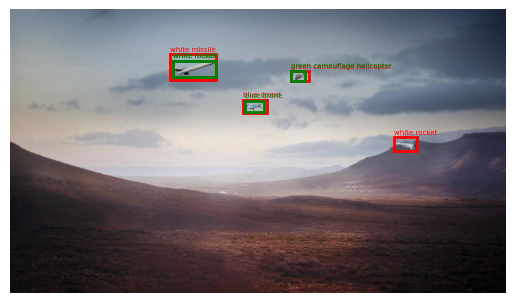

white fighter plane [576, 654, 84, 48] [718.6726684570312, 220.8579864501953, 52.75726318359375, 58.35383605957031]
blue fighter plane [1235, 512, 90, 51] [718.6726684570312, 220.8579864501953, 52.75726318359375, 58.35383605957031]
orange camouflage fighter jet [474, 282, 107, 61] [472.2866516113281, 284.75048828125, 100.85446166992188, 50.0628662109375]
brown fighter jet [267, 294, 122, 69] [472.2866516113281, 284.75048828125, 100.85446166992188, 50.0628662109375]


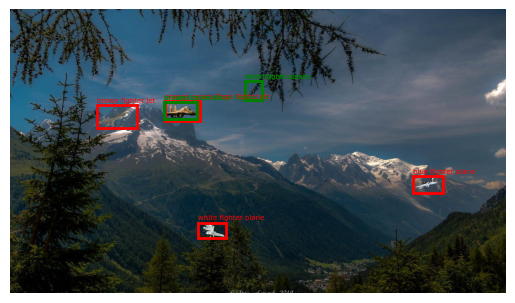

black drone [1122, 359, 150, 86] [1143.9630126953125, 363.51397705078125, 110.6005859375, 70.6357421875]
black helicopter [175, 398, 105, 60] [187.42538452148438, 400.46600341796875, 64.34146118164062, 54.92694091796875]
red commercial aircraft [937, 192, 97, 55] [952.7476806640625, 193.564208984375, 61.84490966796875, 47.12757873535156]
blue fighter plane [272, 521, 88, 50] [187.42538452148438, 400.46600341796875, 64.34146118164062, 54.92694091796875]


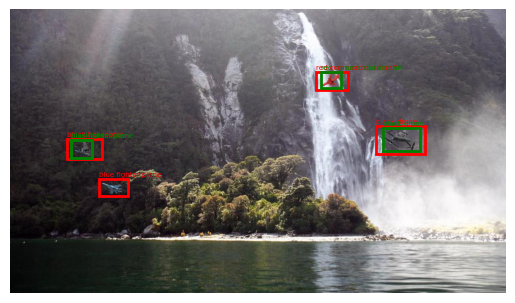

black helicopter [1131, 287, 149, 85] [435.9400634765625, 479.3435974121094, 40.8397216796875, 56.807281494140625]
white commercial aircraft [185, 321, 150, 86] [190.459228515625, 328.3070373535156, 148.85498046875, 65.35116577148438]
black drone [364, 687, 88, 50] [435.9400634765625, 479.3435974121094, 40.8397216796875, 56.807281494140625]
white rocket [483, 318, 151, 86] [537.0645751953125, 337.7565612792969, 222.43609619140625, 82.7264404296875]


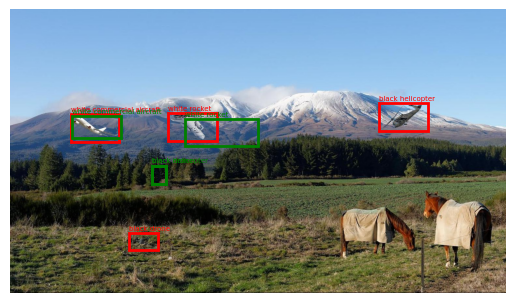

white missile [531, 311, 46, 26] [816.9389038085938, 436.168212890625, 38.93817138671875, 22.83978271484375]
blue cargo aircraft [1199, 389, 127, 72] [816.9389038085938, 436.168212890625, 38.93817138671875, 22.83978271484375]
grey cargo aircraft [806, 435, 52, 29] [1207.8370361328125, 386.7367858886719, 75.476318359375, 51.63470458984375]
white light aircraft [804, 681, 62, 35] [816.9389038085938, 436.168212890625, 38.93817138671875, 22.83978271484375]


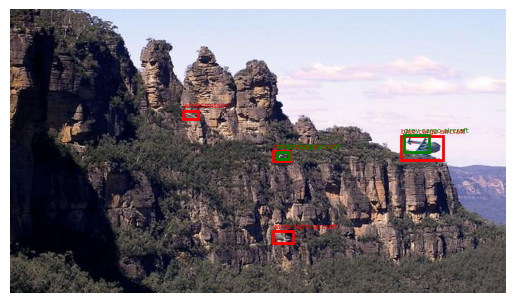

In [27]:
import json
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Paths to the JSON file and the folder with the new images
annotations_json_path = '/content/drive/MyDrive/TIL_personal/combined_annotations.json'
images_dir = '/content/drive/MyDrive/TIL_personal/images_integrated'

# Load the annotations from the JSON file
with open(annotations_json_path, 'r') as json_file:
    annotations_data = json.load(json_file)

# Select 5 random images
random_annotations = random.sample(annotations_data, 5)

# Function to display an image with bounding boxes
def show_image_with_bboxes(image_path, annotations):
    with Image.open(image_path) as img:
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for annotation in annotations:
            bbox = annotation['bbox']
            gen_bbox = annotation['generated_bbox']
            print(annotation['caption'], bbox, gen_bbox)
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            rect2 = patches.Rectangle((gen_bbox[0], gen_bbox[1]), gen_bbox[2], gen_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect2)
            plt.text(bbox[0], bbox[1] - 10, annotation['caption'], color='red', fontsize=5)
            plt.text(gen_bbox[0], gen_bbox[1] - 10, annotation['caption'], color='green', fontsize=5)

        plt.axis('off')
        plt.show()

# Display the 5 selected images with their bounding boxes
for annotation in random_annotations:
    image_name = annotation['image']
    image_path = os.path.join(images_dir, image_name)
    show_image_with_bboxes(image_path, annotation['annotations'])